In [84]:
import json
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from training_data_generation import model_ready_data

In [85]:
def build_model(dense_architecture, input_shape, learning_rate):
    model = Sequential()
    
    # dense layers
    for i in range(len(dense_architecture)):
        width = dense_architecture[i]
        if i == 0:
            model.add(Dense(width, activation="relu", input_shape=input_shape))
        else:
            model.add(Dense(width, activation="relu"))
    
    # add output layer
    model.add(Dense(1, activation="linear"))

    # compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="MeanSquaredError",
                optimizer=optimizer,
                metrics=["MeanAbsoluteError"])
    
    return model

In [86]:
with open("models/nn_1d.json") as f:
    hp = json.load(f)

In [87]:
hp

{'batch_size': 104.40364194547143,
 'learning_rate': 0.0005,
 'min_width': 145.7363732735778,
 'num_epochs': 50.0,
 'num_layers': 3.0}

In [88]:
X_train, X_val, y_train, y_val, auxiliary_train, auxiliary_val = model_ready_data("data/X.csv", "data/y.csv")
input_shape = X_train[0].shape

In [89]:
final_architecture = [int(hp["min_width"])*(2**i) for i in range(int(hp["num_layers"]))]
model = build_model(final_architecture, input_shape, hp["learning_rate"])
model.load_weights("models/nn_1d.h5")

In [90]:
preds = model.predict(X_val)
errors = (preds[:, 0] - y_val[:, 0])
mse = np.mean(errors**2)
mae = np.mean(abs(errors))
mse, mae

437/437 [==============================] - 0s 917us/step


(0.014043603654330964, 0.02386983197825795)

In [91]:
dates = auxiliary_val[:, 0]
total_revenue = auxiliary_val[:, 1]
revenue_per_share = auxiliary_val[:, 2]

In [92]:
results = pd.DataFrame()
results["preds"] = preds[:, 0]
results["true"] = y_val[:, 0]
results["error"] = errors
results["mae"] = mae
results["date"] = dates
results["total_rev"] = total_revenue

In [93]:
def cross_with_true(df, other_column, num_cuts):
    percentiles = []
    for i in range(num_cuts):
        next_percentile = np.nanpercentile(df[other_column], i*100/(num_cuts))
        if next_percentile not in percentiles:
            percentiles.append(round(next_percentile, 5))
    percentiles.append(round(max(df[other_column]), 5))

    formatted_ranges, mean_salaries = [], []
    for i in range(1, len(percentiles)):
        if i != len(percentiles)-1:
            formatted_ranges.append(f"[{round(percentiles[i-1]*100, 2)}, {round(percentiles[i]*100, 2)})")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] < percentiles[i])].true.mean()*100, 2))
        else:
            formatted_ranges.append(f"[{round(percentiles[i-1]*100, 2)}, {round(percentiles[i]*100, 2)}]")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] <= percentiles[i])].true.mean()*100, 2))
    
    display_df = pd.DataFrame()
    display_df[other_column] = formatted_ranges
    display_df["true"] = mean_salaries
    return display_df

In [94]:
cross_with_true(results, "preds", 15)

,preds,true
0,"[-25.73, -1.03)",0.04
1,"[-1.03, -0.02)",0.24
2,"[-0.02, -0.0)",0.21
3,"[-0.0, -0.0)",NaN
4,"[-0.0, -0.0)",NaN
5,"[-0.0, -0.0)",NaN
6,"[-0.0, -0.0)",NaN
7,"[-0.0, -0.0)",NaN
8,"[-0.0, -0.0)",NaN
9,"[-0.0, -0.0)",NaN


(-1.0, 1.0)

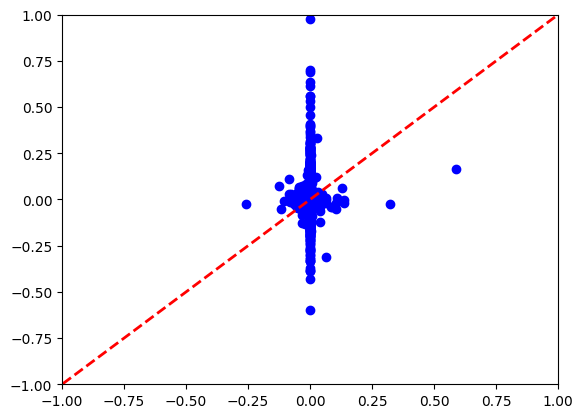

In [95]:
plt.plot(results.preds, results.true, "bo")
plt.plot([-15, 5], [-15, 5], color='red', linestyle='--', linewidth=2, label='Unity line')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [96]:
y_val

array([[-1.19867463e-02,  5.99343031e-03,  3.89571255e-02],
       [ 1.16693240e-03,  1.07354576e-03,  3.50061917e-03],
       [ 2.80011509e-02,  1.31068999e-02,  1.10217139e-02],
       ...,
       [ 1.88674560e-03,  7.73584590e-02, -2.84905693e-01],
       [ 1.76986759e-03,  6.19466315e-03,  9.73448273e-03],
       [ 1.94861065e-04, -1.75404697e-03,  3.31315853e-03]])

In [106]:
results["true"].agg(["min", "mean", "median", "max", "std", "var"])

min       -0.600000
mean       0.002031
median     0.000000
max       11.907240
std        0.116736
var        0.013627
Name: true, dtype: float64

In [109]:
results[(results["true"] > -0.01) & (results["true"] < 0.01)]

,preds,true,error,mae,date,total_rev
1,-0.000002,0.001167,-0.001169,0.02387,2024-04-09 00:00:00-04:00,-1
3,-0.020801,-0.003763,-0.017037,0.02387,2024-03-04 00:00:00-05:00,3791636992
6,0.010553,-0.000228,0.010781,0.02387,2024-06-04 00:00:00-04:00,2908581120
8,-0.000002,0.000000,-0.000002,0.02387,2024-03-07 00:00:00-05:00,-1
9,-0.000002,0.000000,-0.000002,0.02387,2024-04-24 00:00:00-04:00,-1
...,...,...,...,...,...,...
13955,-0.000002,-0.003220,0.003218,0.02387,2024-06-03 00:00:00-04:00,231615008
13960,-0.000002,0.007491,-0.007492,0.02387,2024-05-02 00:00:00-04:00,1641020032
13961,-0.000002,0.001887,-0.001888,0.02387,2024-04-17 00:00:00-04:00,1146427008
13962,0.000501,0.001770,-0.001268,0.02387,2024-03-28 00:00:00-04:00,-1
